#### Importing Python Libraries

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(
    style="whitegrid",
    context="talk",
    palette="deep"
)
import warnings
warnings.filterwarnings("ignore")

#### Data Utilities

In [2]:
def download_prices(
    ticker: str,
    start_date: str = "2016-01-01",
    end_date: str = "2026-01-01",
    auto_adjust: bool = True,
) -> pd.DataFrame:
    """
    Download daily price history from Yahoo Finance and return a clean DataFrame
    with columns: Date, Close (adjusted if auto_adjust=True).
    """
    df = yf.download(
        ticker,
        start=start_date,
        end=end_date,
        auto_adjust=auto_adjust,
        progress=False
    )

    # If yfinance returns multiindex columns (sometimes happens), flatten it.
    if isinstance(df.columns, pd.MultiIndex):
        # Typical layout: ('Close', 'AAPL') etc.
        # Try to drop the "Ticker" level if present, otherwise just take first level.
        try:
            df.columns = df.columns.droplevel("Ticker")
        except Exception:
            df.columns = df.columns.get_level_values(0)

    df = df.reset_index()

    # Standardize expected columns
    if "Close" not in df.columns:
        raise ValueError(f"'Close' column not found for {ticker}. Columns: {df.columns.tolist()}")

    return df[["Date", "Close"]].copy()

In [3]:
def to_prophet_df(df_prices: pd.DataFrame) -> pd.DataFrame:
    """
    Convert a price DataFrame (Date, Close) to Prophet format (ds, y).
    """
    df = df_prices.rename(columns={"Date": "ds", "Close": "y"}).copy()
    df["ds"] = pd.to_datetime(df["ds"])
    return df[["ds", "y"]]

#### Modelling Utilities

In [4]:
def fit_prophet(
    df_prophet: pd.DataFrame,
    yearly_seasonality: bool = True,
    weekly_seasonality: bool = True,
    daily_seasonality: bool = True,
) -> Prophet:
    """
    Fit a Prophet model to df with columns ds, y.
    """
    m = Prophet(
        yearly_seasonality=yearly_seasonality,
        weekly_seasonality=weekly_seasonality,
        daily_seasonality=daily_seasonality,
    )
    m.fit(df_prophet)
    return m

In [5]:
def make_forecast(
    model: Prophet,
    periods: int = 365,
    freq: str = "D",
) -> pd.DataFrame:
    """
    Create future dataframe and generate Prophet forecast.
    """
    future = model.make_future_dataframe(periods=periods, freq=freq)
    forecast = model.predict(future)
    return forecast

#### Feature Summaries (Month / Weekday)

In [6]:
def monthly_summary(forecast: pd.DataFrame) -> pd.DataFrame:
    """
    Return average yhat by month (1-12).
    """
    out = forecast.copy()
    out["month"] = pd.to_datetime(out["ds"]).dt.month
    return out.groupby("month", as_index=False)["yhat"].mean()

In [7]:
def weekday_summary(
    forecast: pd.DataFrame,
    weekly_order=None,
) -> pd.DataFrame:
    """
    Return average yhat by weekday, ordered.
    """
    if weekly_order is None:
        weekly_order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]

    out = forecast.copy()
    out["weekday"] = pd.to_datetime(out["ds"]).dt.day_name()
    grouped = out.groupby("weekday", as_index=False)["yhat"].mean()

    # Order rows
    grouped["weekday"] = pd.Categorical(grouped["weekday"], categories=weekly_order, ordered=True)
    grouped = grouped.sort_values("weekday").reset_index(drop=True)
    return grouped

#### Plotting the Graphs

In [8]:
def plot_actual_vs_forecast(
    df_prophet: pd.DataFrame,
    forecast: pd.DataFrame,
    ticker: str,
    figsize=(14, 6),
):
    plt.figure(figsize=figsize)

    # Actual
    sns.lineplot(
        data=df_prophet,
        x="ds",
        y="y",
        label="Actual",
        linewidth=2
    )

    # Forecast
    sns.lineplot(
        data=forecast,
        x="ds",
        y="yhat",
        label="Forecast",
        linewidth=2
    )

    # Confidence Interval
    plt.fill_between(
        forecast["ds"],
        forecast["yhat_lower"],
        forecast["yhat_upper"],
        alpha=0.25,
        label="Confidence Interval"
    )

    plt.title(f"{ticker} – Actual vs Forecast Price")
    plt.xlabel("Date")
    plt.ylabel("Adjusted Close (USD)")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [9]:
def plot_component_series(
    forecast: pd.DataFrame,
    component: str,
    ticker: str,
    title: str = None,
    figsize=(14, 5),
):
    if component not in forecast.columns:
        raise ValueError(f"Component '{component}' not found in forecast columns.")

    plt.figure(figsize=figsize)

    sns.lineplot(
        data=forecast,
        x="ds",
        y=component,
        linewidth=2
    )

    plt.title(title or f"{ticker} – {component.title()} Component")
    plt.xlabel("Date")
    plt.ylabel("Seasonality Effect")
    plt.tight_layout()
    plt.show()

In [10]:
def plot_monthly_component(
    monthly_df: pd.DataFrame,
    ticker: str,
    figsize=(12, 5),
):
    plt.figure(figsize=figsize)

    sns.lineplot(
        data=monthly_df,
        x="month",
        y="yhat",
        marker="o",
        linewidth=2
    )

    plt.title(f"{ticker} – Monthly Component (Avg Forecasted Price)")
    plt.xlabel("Month")
    plt.ylabel("Average Forecasted Price")
    plt.xticks(range(1, 13))
    plt.tight_layout()
    plt.show()

In [11]:
def plot_weekly_component(
    weekday_df: pd.DataFrame,
    ticker: str,
    figsize=(12, 5),
):
    plt.figure(figsize=figsize)

    sns.barplot(
        data=weekday_df,
        x="weekday",
        y="yhat",
        estimator=np.mean
    )

    plt.title(f"{ticker} – Weekly Component (Avg Forecasted Price)")
    plt.xlabel("Day of Week")
    plt.ylabel("Average Forecasted Price")
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

#### Pipeline for Ticker

In [12]:
def run_ticker_pipeline(
    ticker: str,
    start_date: str = "2016-01-01",
    end_date: str = "2026-01-01",
    forecast_days: int = 365,
    weekly_order=None,
    plot: bool = True,
):
    """
    End-to-end pipeline for a single ticker:
    download -> prophet df -> fit -> forecast -> monthly/weekday summaries -> plots (optional)
    """
    if weekly_order is None:
        weekly_order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]

    prices = download_prices(ticker, start_date, end_date, auto_adjust=True)
    df_p = to_prophet_df(prices)

    model = fit_prophet(df_p, yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
    forecast = make_forecast(model, periods=forecast_days, freq="D")

    m_summary = monthly_summary(forecast)
    w_summary = weekday_summary(forecast, weekly_order=weekly_order)

    if plot:
        plot_actual_vs_forecast(df_p, forecast, ticker)
        plot_component_series(forecast, "trend", ticker, title=f"{ticker} - Trend Component")
        plot_component_series(forecast, "yearly", ticker, title=f"{ticker} - Yearly Seasonality")
        plot_monthly_component(m_summary, ticker)
        plot_weekly_component(w_summary, ticker)

    return {
        "ticker": ticker,
        "prices": prices,
        "df_prophet": df_p,
        "model": model,
        "forecast": forecast,
        "monthly": m_summary,
        "weekly": w_summary,
    }

#### Multi-Ticker Comparison Plots

In [13]:
def plot_yearly_seasonality_comparison(results: dict, figsize=(16, 10)):
    """
    results: dict[ticker -> output of run_ticker_pipeline]
    """
    tickers = list(results.keys())
    fig, axes = plt.subplots(len(tickers), 1, figsize=figsize, sharex=True)

    if len(tickers) == 1:
        axes = [axes]

    for ax, t in zip(axes, tickers):
        fc = results[t]["forecast"]
        ax.plot(fc["ds"], fc["yearly"], linewidth=2)
        ax.set_title(f"{t} - Yearly Seasonality")
        ax.set_ylabel("Seasonality Effect")

    axes[-1].set_xlabel("Date")
    plt.suptitle("Yearly Seasonality Comparison", fontsize=15)
    plt.tight_layout()
    plt.show()

In [14]:
def plot_monthly_component_comparison(results: dict, figsize=(14, 10)):
    tickers = list(results.keys())
    fig, axes = plt.subplots(len(tickers), 1, figsize=figsize, sharex=True)

    if len(tickers) == 1:
        axes = [axes]

    for ax, t in zip(axes, tickers):
        mdf = results[t]["monthly"]
        ax.plot(mdf["month"], mdf["yhat"], marker="o", linewidth=2)
        ax.set_title(f"{t} - Monthly Component")
        ax.set_ylabel("Avg Forecasted Price")
        ax.set_xticks(range(1, 13))
        ax.grid(alpha=0.3)

    axes[-1].set_xlabel("Month")
    plt.suptitle("Monthly Component Comparison", fontsize=15)
    plt.tight_layout()
    plt.show()

In [15]:
def plot_weekly_component_comparison(results: dict, weekly_order=None, figsize=(18, 5)):
    if weekly_order is None:
        weekly_order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]

    tickers = list(results.keys())
    fig, axes = plt.subplots(1, len(tickers), figsize=figsize, sharey=True)

    if len(tickers) == 1:
        axes = [axes]

    for ax, t in zip(axes, tickers):
        wdf = results[t]["weekly"]
        # ensure ordering
        wdf = wdf.copy()
        wdf["weekday"] = pd.Categorical(wdf["weekday"], categories=weekly_order, ordered=True)
        wdf = wdf.sort_values("weekday")

        ax.bar(wdf["weekday"].astype(str), wdf["yhat"])
        ax.set_title(t)
        ax.set_xlabel("Day of Week")
        ax.tick_params(axis="x", rotation=30)

    axes[0].set_ylabel("Average Forecasted Price")
    plt.suptitle("Weekly Component Comparison", fontsize=15)
    plt.tight_layout()
    plt.show()

#### Multiple Ticker Usage

15:42:01 - cmdstanpy - INFO - Chain [1] start processing
15:42:02 - cmdstanpy - INFO - Chain [1] done processing


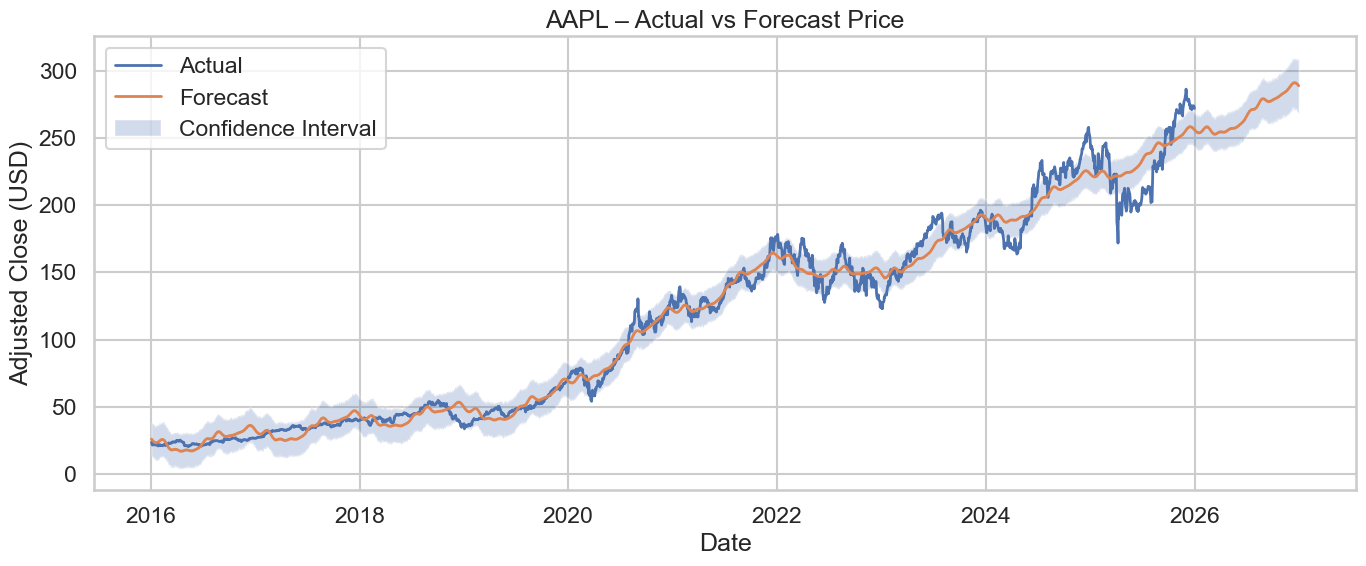

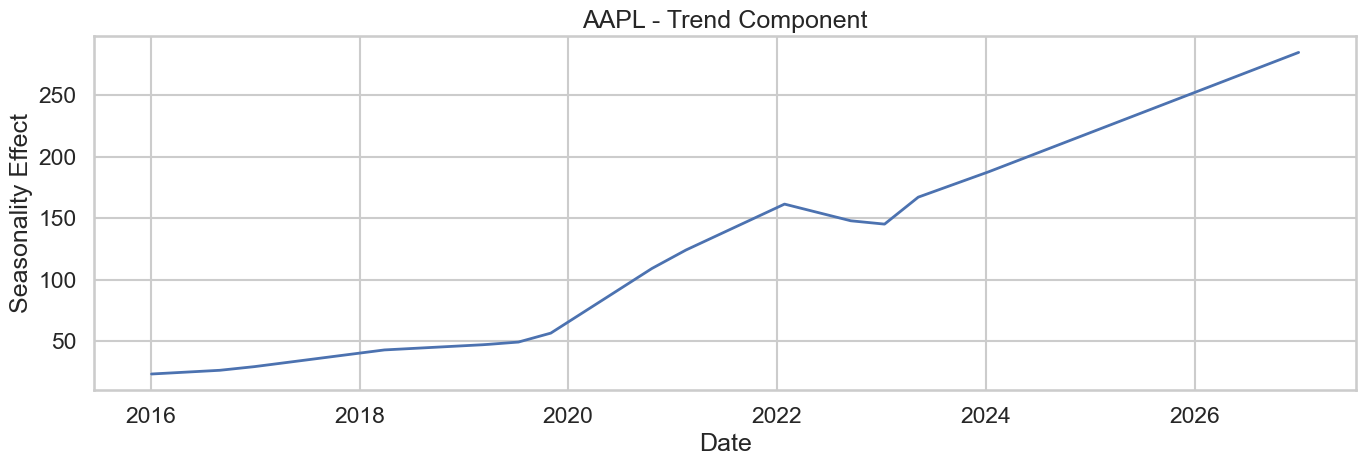

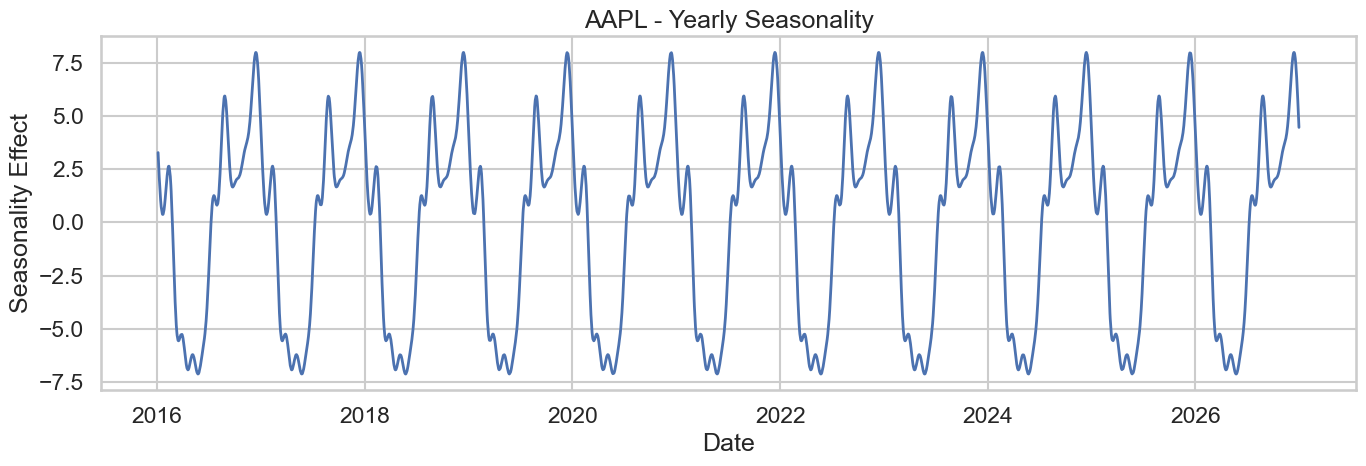

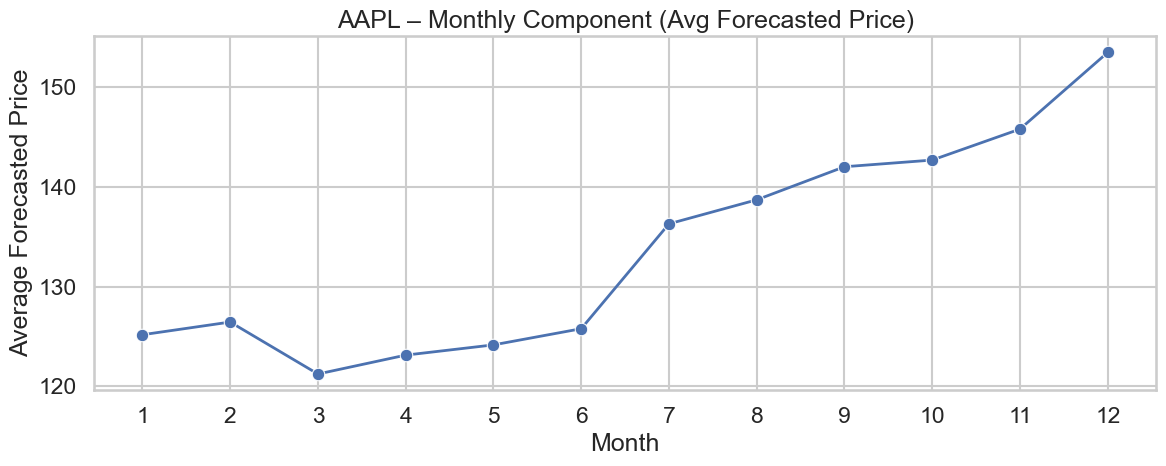

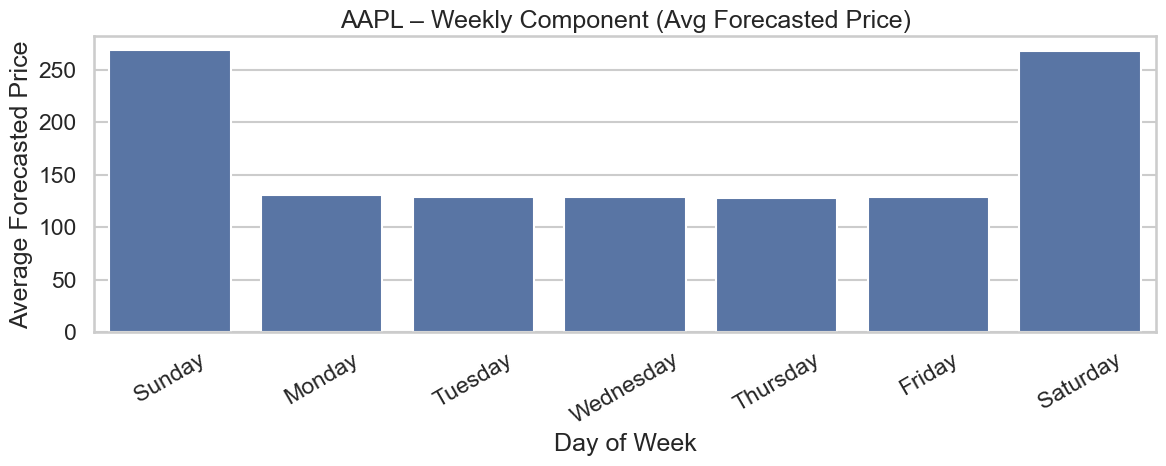

15:42:03 - cmdstanpy - INFO - Chain [1] start processing
15:42:03 - cmdstanpy - INFO - Chain [1] done processing


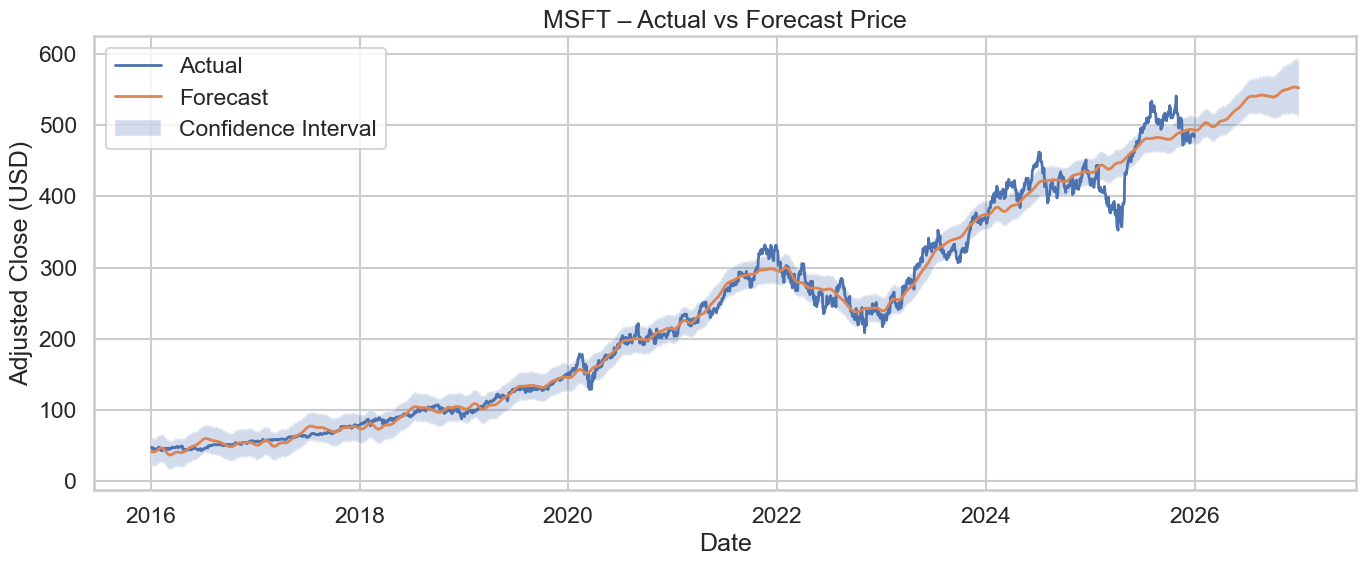

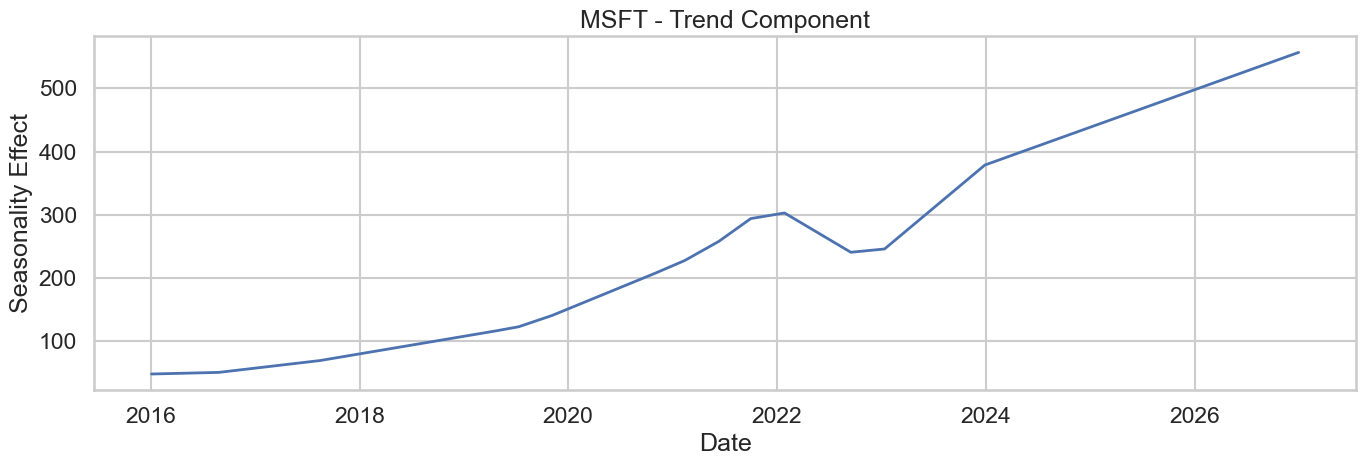

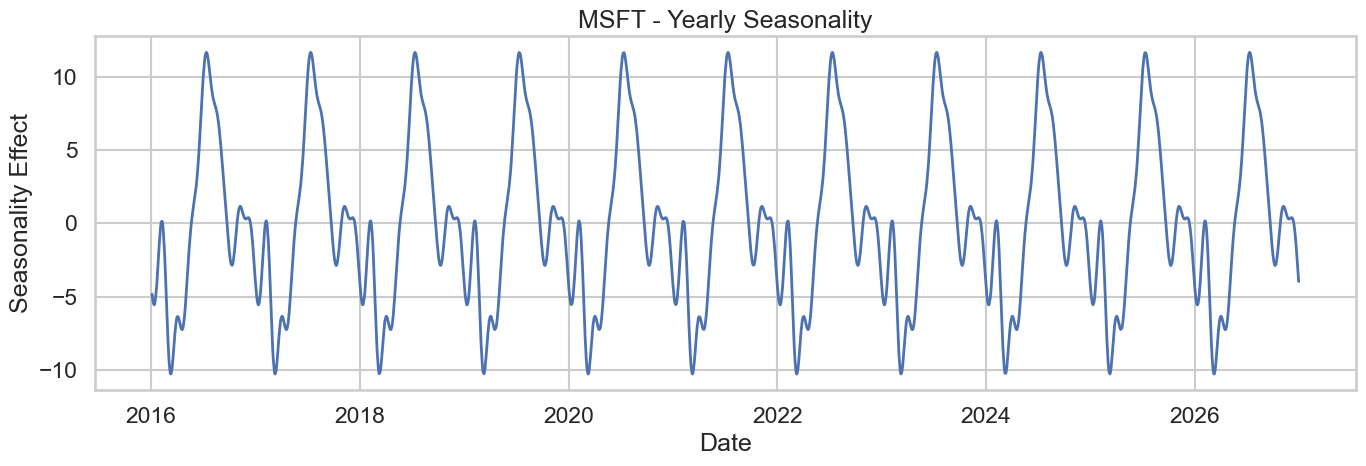

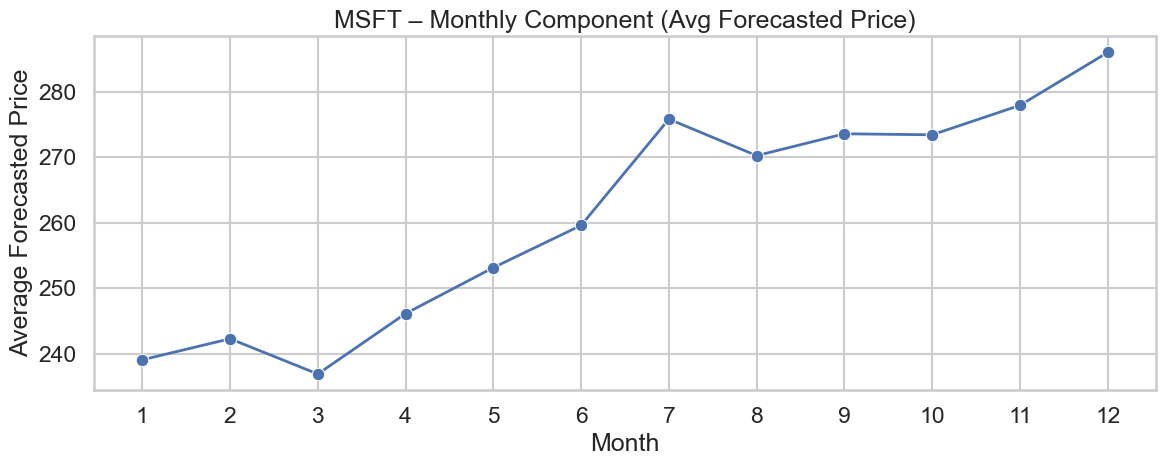

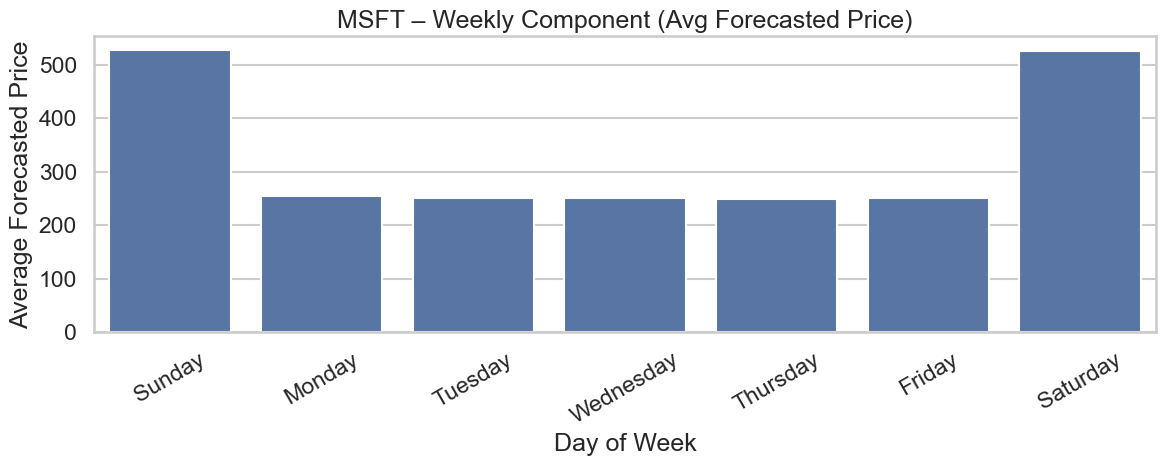

15:42:05 - cmdstanpy - INFO - Chain [1] start processing
15:42:05 - cmdstanpy - INFO - Chain [1] done processing


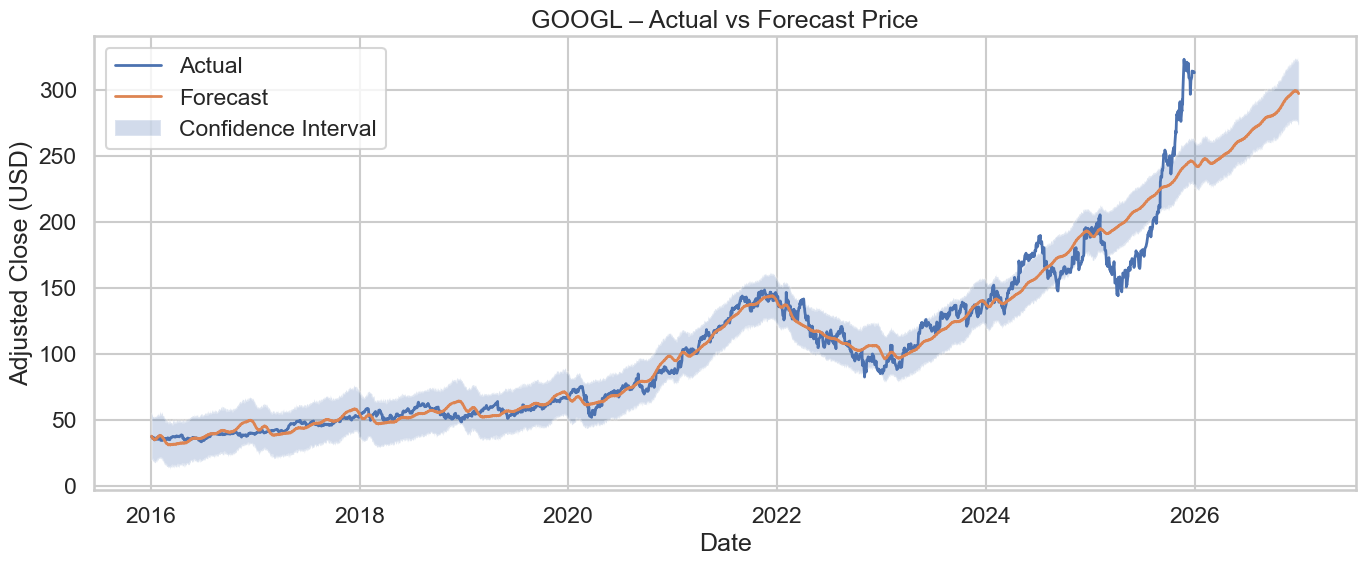

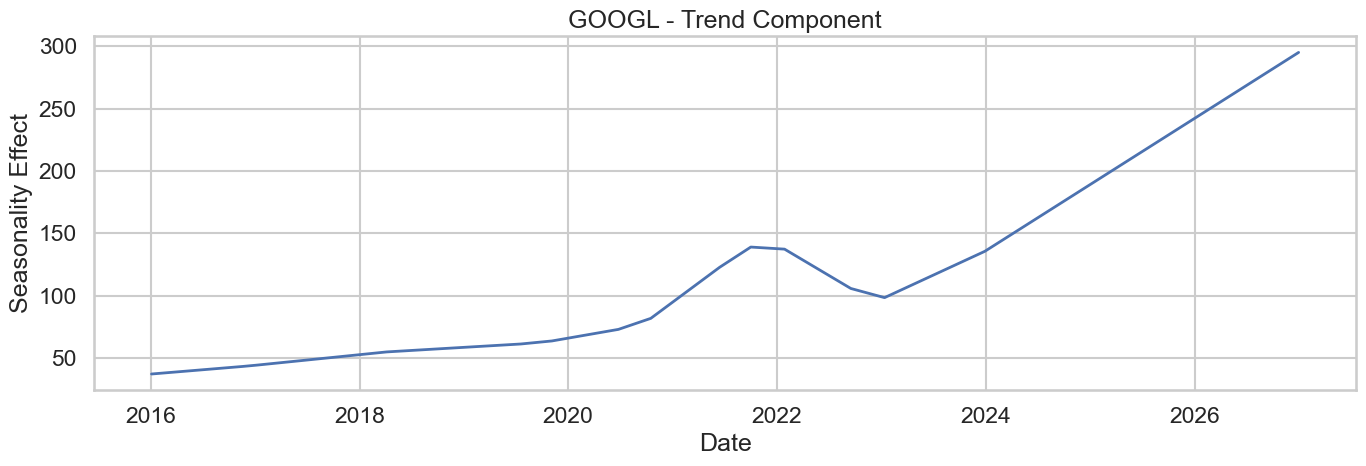

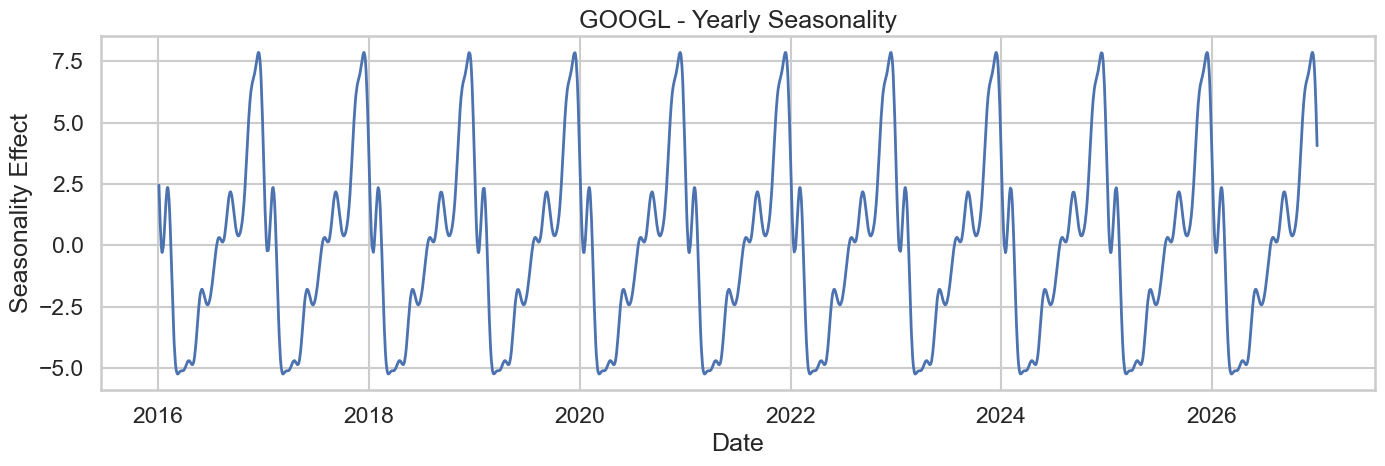

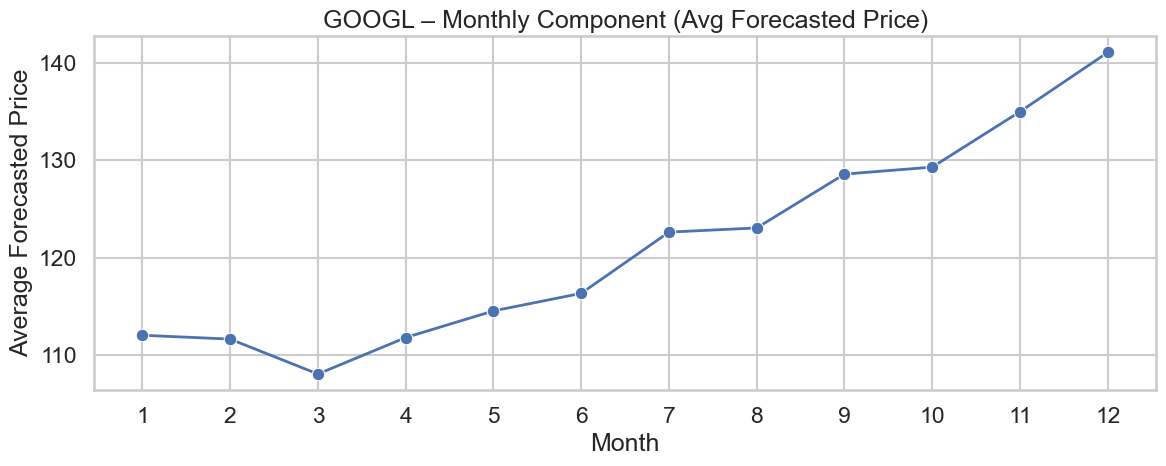

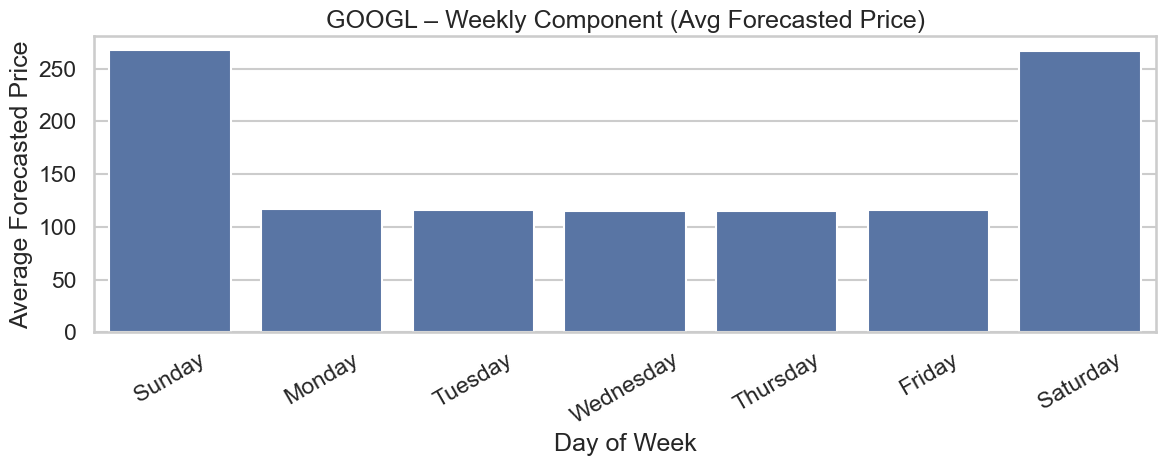

In [16]:
tickers = ["AAPL", "MSFT", "GOOGL"]

results = {
    t: run_ticker_pipeline(
        ticker=t,
        start_date="2016-01-01",
        end_date="2026-01-01",
        forecast_days=365,
        plot=True
    )
    for t in tickers
}

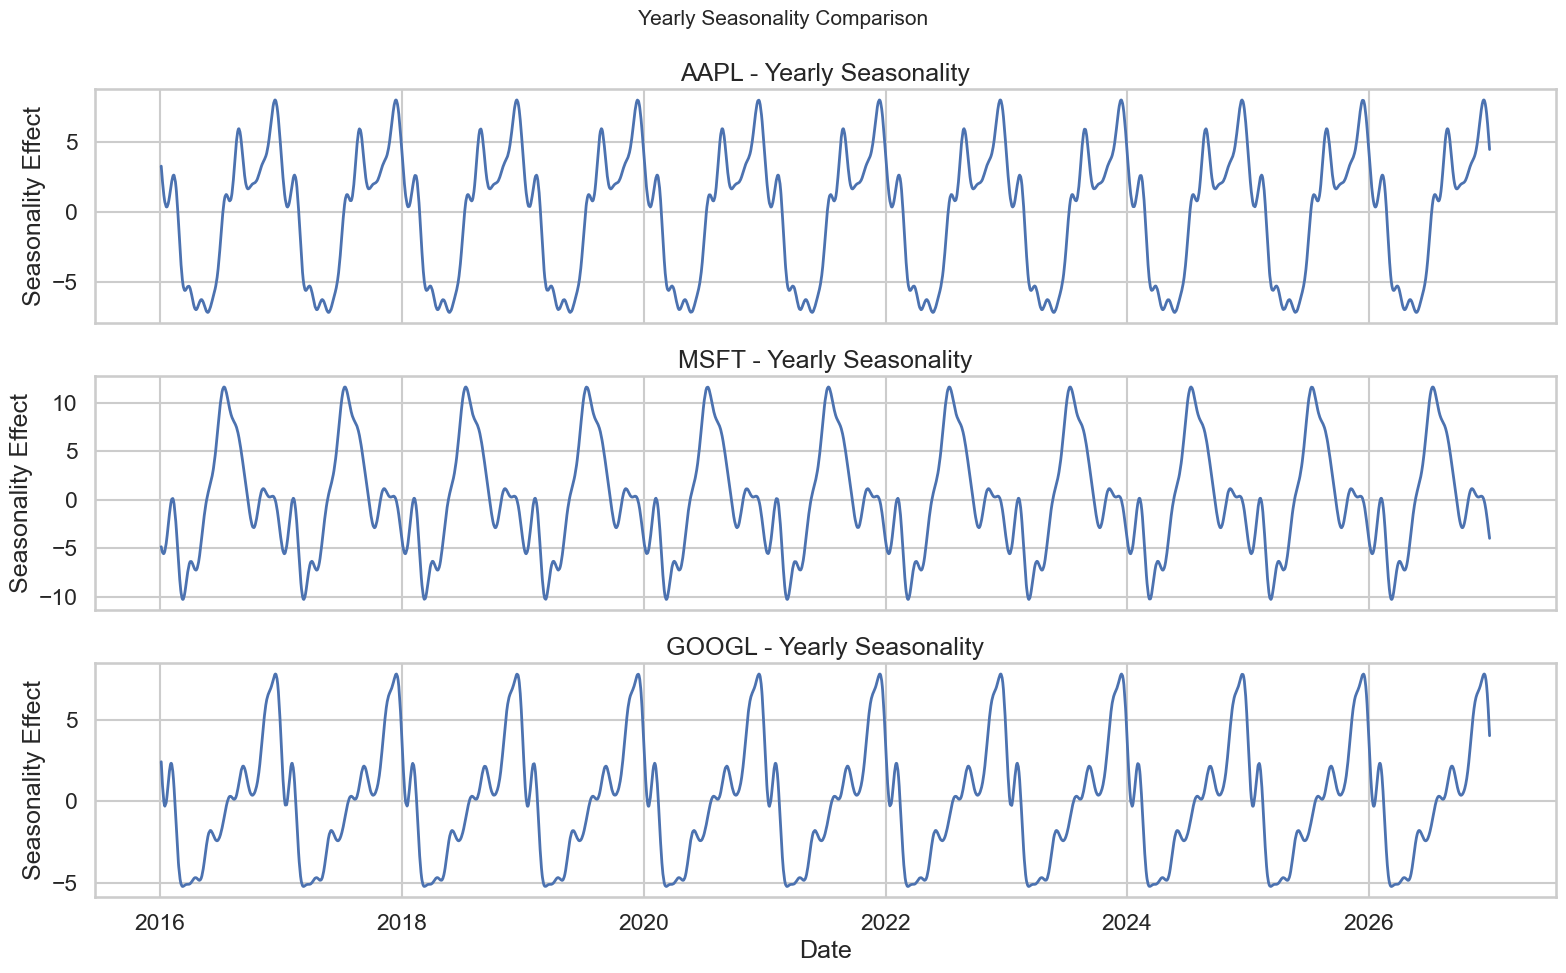

In [17]:
plot_yearly_seasonality_comparison(results)

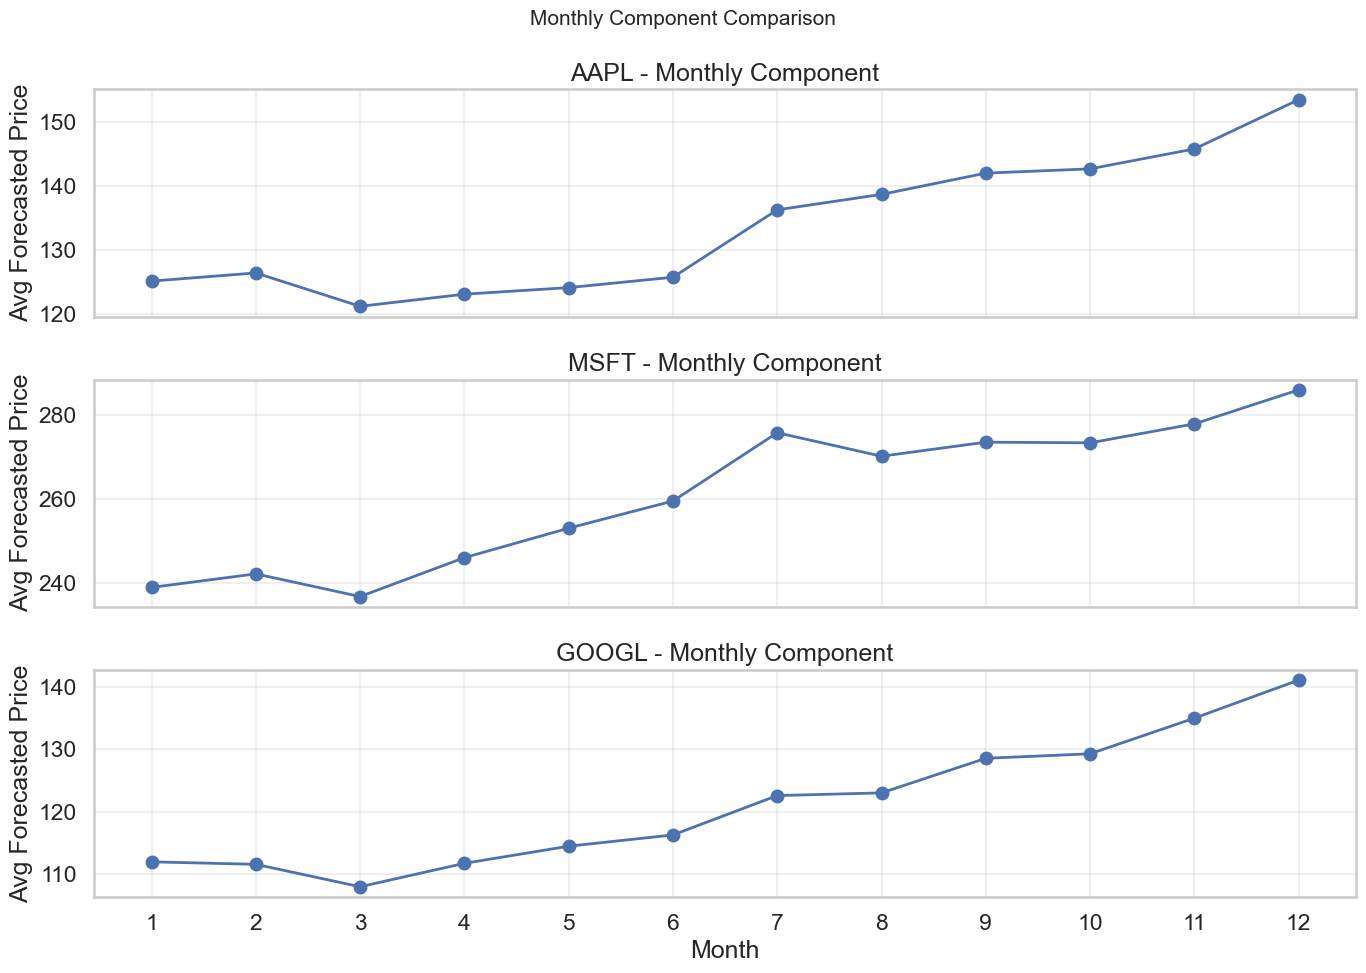

In [18]:
plot_monthly_component_comparison(results)

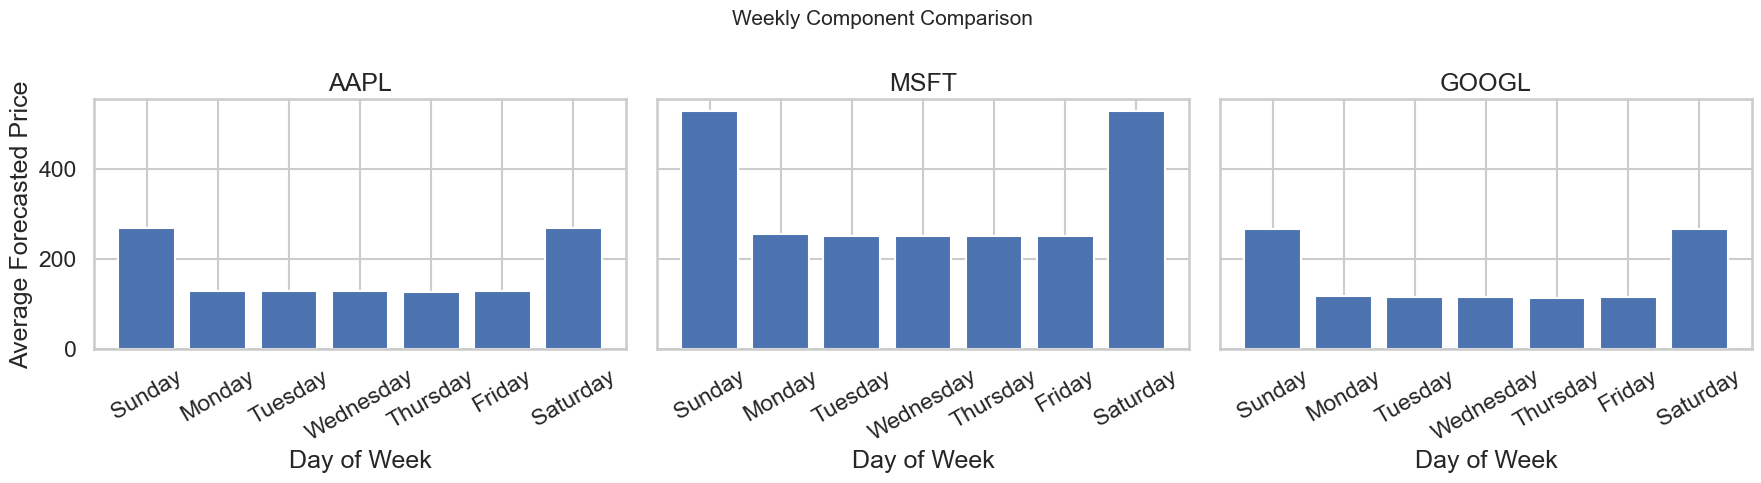

In [19]:
plot_weekly_component_comparison(results)